In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression,LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')

In [3]:
train = train[train['time_spent']<6000]

In [4]:
# train['time_spent'] = np.log(train['time_spent'])

In [5]:
train.drop(['session_id','session_number','client_agent'],axis = 1,inplace = True)
test.drop(['session_id','session_number','client_agent'],axis = 1,inplace = True)

In [6]:
train['date'] = train['date'].astype('datetime64')
test['date'] = test['date'].astype('datetime64')

In [7]:
train['dayofyear'] = train['date'].dt.dayofyear
test['dayofyear'] = test['date'].dt.dayofyear
train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

In [8]:
train.drop('date',axis = 1,inplace = True)
test.drop('date',axis = 1,inplace = True)

In [9]:
def new_cols(column,val):
    return [i.split('-')[val].strip() for i in column]

In [10]:
train['device'] = new_cols(train['device_details'],0)
test['device'] = new_cols(test['device_details'],0)

train['platform'] = new_cols(train['device_details'],1)
test['platform'] = new_cols(test['device_details'],1)

In [11]:
train['activity_class'] = train['purchased']+train['added_in_cart']+train['checked_out']
test['activity_class'] = test['purchased']+test['added_in_cart']+test['checked_out']

In [12]:
train.drop('device_details',axis = 1,inplace = True)
test.drop('device_details',axis = 1,inplace = True)

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


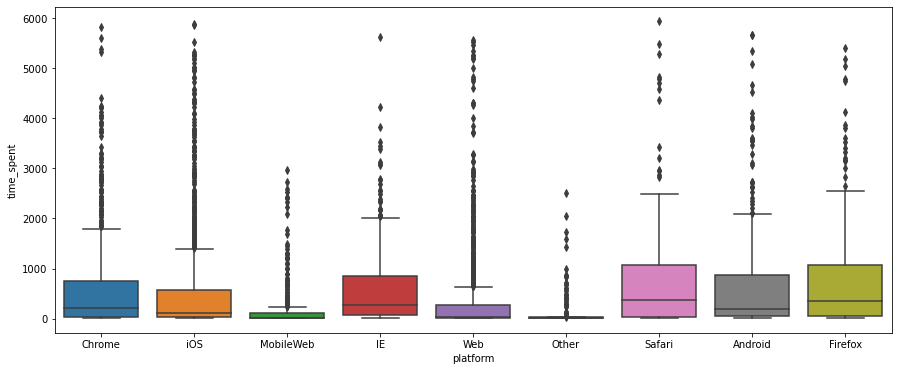

In [13]:
plt.figure(figsize = (15,6))
sns.boxplot('platform','time_spent',data = train)

In [15]:
train['device'].unique()

array(['Desktop', 'iPhone', 'Android Tablet', 'iPad', 'Other',
       'Android Phone', 'Unknown'], dtype=object)

In [19]:
def imputing_device(column):
    if column in ['iPhone','Android Phone']:
        return 'Phone'
    elif column in ['iPad','Android Tablet']:
        return 'Tablet'
    else:
        return column

In [21]:
train['device_lesser_dim'] = train['device'].apply(imputing_device)

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


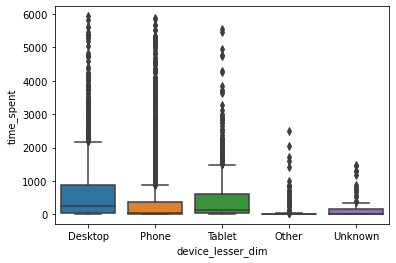

In [22]:
sns.boxplot('device_lesser_dim',train['time_spent'],data = train)

In [52]:
train

,purchased,added_in_cart,checked_out,time_spent,dayofyear,month,device,platform,activity_class
0,1,0,0,5.467579,22,1,Desktop,Chrome,1
1,1,0,0,7.152625,58,2,iPhone,iOS,1
2,0,0,0,3.077497,213,8,iPhone,MobileWeb,0
3,0,1,0,6.120739,364,12,Desktop,IE,1
4,0,0,0,7.060371,253,9,iPhone,Web,0
...,...,...,...,...,...,...,...,...,...
5424,0,0,0,3.025340,324,11,iPhone,Web,0
5425,0,0,0,7.338021,269,9,iPhone,iOS,0
5426,0,0,0,3.122849,225,8,Desktop,Chrome,0
5427,0,0,0,3.037066,169,6,Unknown,MobileWeb,0


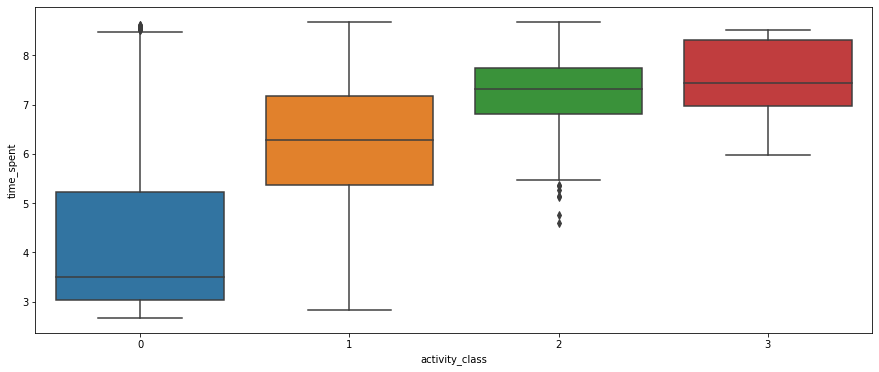

In [14]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'activity_class',y = 'time_spent',data = train)
plt.show()

In [15]:
import category_encoders as ec
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

C:\Users\tejas\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
he = ec.HashingEncoder(cols = ['device','platform'])
train = he.fit_transform(train)
test = he.fit_transform(test)

C:\Users\tejas\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [17]:
traffic = dict(train.groupby('dayofyear')['dayofyear'].count())
train['trafficbyday'] = train['dayofyear'].map(traffic)
test['trafficbyday'] = test['dayofyear'].map( traffic)

In [18]:
trafficbm = dict(train.groupby('month')['month'].count())
train['trafficbymonth'] = train['month'].map(trafficbm)
test['trafficbymonth'] = test['month'].map(trafficbm)

# Trying Logistic Regression first

In [19]:
ss = MinMaxScaler()
for i in ['dayofyear','month','trafficbyday','trafficbymonth','activity_class']:
    train[i] = ss.fit_transform(np.array(train[i]).reshape(-1,1))

In [20]:
train['binary_Class']=[0 if train['activity_class'][i]<=0 else 1 for i in range(len(train))]

In [21]:
train['binary_Class'].value_counts()

0    3805
1    1541
Name: binary_Class, dtype: int64

In [22]:
y = train['binary_Class']
X = train.drop(['time_spent','binary_Class'],axis = 1)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 6)
lgr = LogisticRegression()
lgr.fit(x_train,y_train)

C:\Users\tejas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
lgr.score(x_test,y_test)

0.9990654205607477

###### Add logistic reg predictions to test set

# Now apply regression

In [25]:
y = train['time_spent']
X = train.drop(['time_spent'],axis = 1)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 6)

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.05664178560837699

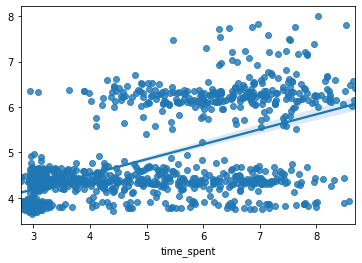

In [26]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = abs(lr.predict(x_test))
sns.regplot(y_test,y_pred)
mean_squared_log_error(y_test,y_pred)

In [27]:
Q1 = train['time_spent'].quantile(0.25)
Q3 = train['time_spent'].quantile(0.75)
IQR = Q3-Q1
outlier = Q3+1.5*IQR
outlier

11.116370001078959

In [28]:
train

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,purchased,added_in_cart,checked_out,time_spent,dayofyear,month,activity_class,trafficbyday,trafficbymonth,binary_Class
0,1,0,0,0,1,0,0,0,1,0,0,5.467579,0.057692,0.000000,0.333333,0.589744,0.658741,1
1,0,1,0,1,0,0,0,0,1,0,0,7.152625,0.156593,0.090909,0.333333,0.307692,0.620979,1
2,1,1,0,0,0,0,0,0,0,0,0,3.077497,0.582418,0.636364,0.000000,0.538462,0.566434,0
3,1,0,0,0,0,0,0,1,0,1,0,6.120739,0.997253,1.000000,0.333333,0.846154,0.965035,1
4,1,1,0,0,0,0,0,0,0,0,0,7.060371,0.692308,0.727273,0.000000,0.743590,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,1,1,0,0,0,0,0,0,0,0,0,3.025340,0.887363,0.909091,0.000000,0.538462,0.699301,0
5342,0,1,0,1,0,0,0,0,0,0,0,7.338021,0.736264,0.727273,0.000000,0.410256,1.000000,0
5343,1,0,0,0,1,0,0,0,0,0,0,3.122849,0.615385,0.636364,0.000000,0.410256,0.566434,0
5344,1,0,0,0,0,0,1,0,0,0,0,3.037066,0.461538,0.454545,0.000000,0.128205,0.215385,0


C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.05672071942399767, 0.32322905319962014)

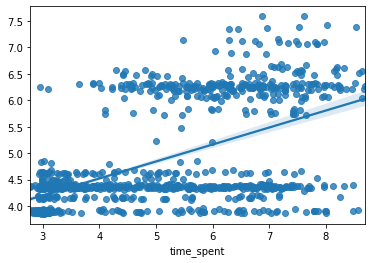

In [29]:
from sklearn.linear_model import ElasticNet
lr = ElasticNet(alpha=0.01)
lr.fit(x_train,y_train)
lr.score(x_test,y_test)
y_pred = lr.predict(x_test)

sns.regplot(y_test,y_pred)
mean_squared_log_error(y_test,y_pred),lr.score(x_test,y_test)

C:\Users\tejas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


2.321368391511559

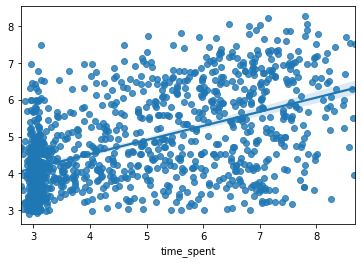

In [31]:
from sklearn.ensemble import RandomForestRegressor
rand_clf = RandomForestRegressor()
rand_clf.fit(x_train,y_train)
y_pred = rand_clf.predict(x_test)
Y_pred = np.exp(y_pred)
Y_test = np.exp(y_test)
sns.regplot(y_test,y_pred)
mean_squared_log_error(Y_test,Y_pred)